In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

import copy
import traceback
import datetime
import joblib
import re
import os
import random
import string
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchtext import data
from torchtext import datasets
from torchtext import vocab
from torchtext.vocab import Vectors, GloVe

from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import pymorphy2
from sklearn.base import BaseEstimator, TransformerMixin

In [103]:
class ConfigExperiment:
    seed = 42
    positive_file = "../data/positive.csv"
    negative_file = "../data/negative.csv"
    test_size = 0.3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embed_dim = 300
    max_vocab_size = 50_000
    batch_size = 64
    num_epochs = 30
    lr = 1e-2
    num_workers = 0
    patience = 3
    early_stopping_delta = 1e-4
    save_dirname = "models"
    
config = ConfigExperiment()

In [104]:
def init_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic=True
    
init_random_seed(config.seed)

In [151]:
column_names = ["id", "tdate", "tmane", "ttext", "ttype", "trep", "trtw", "tfav", "tstcount", "tfoll", "tfrien", "listcount"]
positive_df = pd.read_csv(config.positive_file, sep=";", names=column_names, index_col=False)
negative_df = pd.read_csv(config.negative_file, sep=";", names=column_names, index_col=False)

df = pd.concat([negative_df, positive_df])
# df.drop(["ttype", "tfav"], axis=1, inplace=True)
# df.columns = ["id", "tdate", "tmane", "text", "trep", "target", "tstcount", "tfoll", "tfrien", "listcount"]

df.shape, negative_df.shape, positive_df.shape

((226834, 12), (111923, 12), (114911, 12))

In [155]:
df = pd.read_pickle("full_dataset.pkl")

In [156]:
df.head()

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
0,408906691322073088,1386325926,AndreyAF,Грустный суворовец с пятым айфоном.,2,0,0,0,25914,175,113,23
1,408906691338854400,1386325927,kydijamipam,RT @juvivenofara: ненавижу 10рублевый металл.....,2,0,2,0,372,67,63,0
2,408906691347226624,1386325927,zgamaset,RT @tourskidki_ru: Тур во Вьетнам (Нячанг) на ...,2,0,3,0,2738,2779,2979,3
3,408906691414331392,1386325927,my_wedding_ua,рппр,2,0,0,0,1,0,2,0
4,408906691430739968,1386325927,Ronisan12,"Добралась до ночлега, не хоромы, но переночева...",2,0,0,0,1347,12,6,0


In [160]:
df.shape

(17639674, 12)

In [161]:
df.trtw.value_counts()

0        14380750
1         1321567
2          339673
3          188658
4          128049
           ...   
5469            1
5472            1
5478            1
5483            1
20063           1
Name: trtw, Length: 8041, dtype: int64

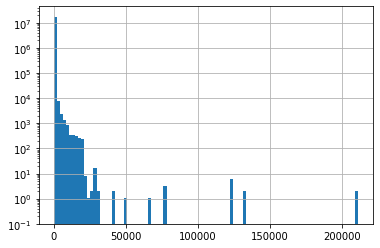

In [162]:
fig, ax = plt.subplots()
df.trtw.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

(0.0, 50000.0)

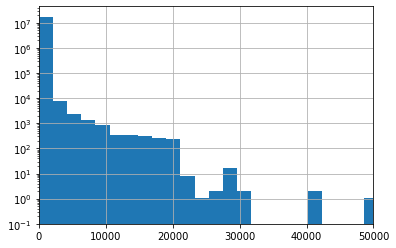

In [166]:
fig, ax = plt.subplots()
df.trtw.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
plt.xlim((0, 50000))

In [41]:
# df["text"].tolist()[:40]

In [42]:
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    # Remove digits
    text = re.sub("\d+:\d+", " ", text)
    text = re.sub(" \d+", " ", text)
    # Removing ';quot;'
    text = re.sub(';quot;', '', text) 
    # Removing ';quot;'
    text = re.sub('&amp', '', text) 
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', ' ', text)
    #Convert @username to AT_USER
    text = re.sub('@[^\s]+','AT_USER', text)
    #Removing @mentions
    text = re.sub('@[A-Za-z0–9]+', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    # Removing '#' hash tag
    text = re.sub('#', '', text) 
    # Removing RT
    text = re.sub('rt[\s]+', '', text) 
    # Removing hyperlink
    text = re.sub('https?:\/\/\S+', '', text)
    # Separate words and punctuation
    text = re.findall(r"[\w']+|[.,!?;:()]", text)
    text = " ".join(text)
    return text

In [43]:
# Clean the tweets
df['text'] = df['text'].apply(preprocess_text)

In [44]:
# df["text"].tolist()[:40]

In [45]:
cache = {}
morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def lemmatize(text):
    words = []
    for token in text.split():
        # Если токен уже был закеширован, быстро возьмем результат из кэша.
        if token in cache.keys():
            words.append(cache[token])
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            result = morph.parse(token)   
            word = result[0].normal_form
            # Отправляем слово в результат, ...
            words.append(word)
            # ... и кешируем результат его разбора.
            cache[token] = word   
    return ' '.join(words)

In [46]:
%%time

df['text'] = df['text'].apply(lemmatize)

CPU times: user 40 s, sys: 23.9 ms, total: 40 s
Wall time: 40 s


In [47]:
df.head()

,id,tdate,tmane,text,trep,target,tstcount,tfoll,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работа быть полный пиддес : и так каждый за...,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"коллега сидеть рубиться в urban terror , а я и...",0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,at_user как говорят обещаной три год ждать . ....,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"желать хороший полёт и удачный посадка , я быт...",0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"обновить за какой то леший surf , теперь не ра...",0,0,35,17,34,0


In [48]:
df.drop(["id", "tmane", "trep"], axis=1, inplace=True)

In [105]:
df.head()

,tdate,text,target,tstcount,tfoll,tfrien,listcount
0,1386325944,на работа быть полный пиддес : и так каждый за...,0,8064,111,94,2
1,1386325957,"коллега сидеть рубиться в urban terror , а я и...",0,26,42,39,0
2,1386325966,at_user как говорят обещаной три год ждать . ....,0,718,49,249,0
3,1386325980,"желать хороший полёт и удачный посадка , я быт...",0,10628,207,200,0
4,1386325980,"обновить за какой то леший surf , теперь не ра...",0,35,17,34,0


In [108]:
def time_enginiring(row):
    t = pd.to_datetime(row["tdate"], unit='s')
    row["year"] = t.year
    row["month"] =  t.month
    row["day"] = t.day
    row["dayofweek"] = t.dayofweek
    row["week"] = t.week
    row["hour"] = t.hour
    return row

In [109]:
df = df.apply(time_enginiring, axis=1)

In [110]:
df.drop(["tdate"], axis=1, inplace=True)

In [111]:
df.head()

,text,target,tstcount,tfoll,tfrien,listcount,year,month,day,dayofweek,week,hour
0,на работа быть полный пиддес : и так каждый за...,0,8064,111,94,2,2013,12,6,4,49,10
1,"коллега сидеть рубиться в urban terror , а я и...",0,26,42,39,0,2013,12,6,4,49,10
2,at_user как говорят обещаной три год ждать . ....,0,718,49,249,0,2013,12,6,4,49,10
3,"желать хороший полёт и удачный посадка , я быт...",0,10628,207,200,0,2013,12,6,4,49,10
4,"обновить за какой то леший surf , теперь не ра...",0,35,17,34,0,2013,12,6,4,49,10


In [112]:
# df.to_csv("../data/processed_data_regression.csv", index=False)

In [125]:
df = pd.read_csv("../data/processed_data_regression.csv", index_col=False)

In [126]:
from sklearn import preprocessing

In [127]:
x = df[["tstcount", "tfoll", "tfrien", "listcount", "year", "month", "day", "dayofweek", "week", "week", "hour"]].values

In [128]:
min_max_scaler = preprocessing.MinMaxScaler()

In [129]:
x_scaled = min_max_scaler.fit_transform(x)

In [132]:
d = pd.DataFrame(x_scaled, columns=["tstcount", "tfoll", "tfrien", "listcount", "year", "month", "day", "dayofweek", "week", "week", "hour"])

In [133]:
d

,tstcount,tfoll,tfrien,listcount,year,month,day,dayofweek,week,week,hour
0,0.007082,0.000070,0.000242,0.000118,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
1,0.000023,0.000027,0.000100,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
2,0.000631,0.000031,0.000641,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
3,0.009334,0.000131,0.000515,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
4,0.000031,0.000011,0.000088,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
...,...,...,...,...,...,...,...,...,...,...,...
226829,0.001315,0.000035,0.000088,0.000118,0.0,1.0,0.400000,0.666667,0.960784,0.960784,0.217391
226830,0.000608,0.000142,0.000541,0.000000,0.0,1.0,0.400000,0.666667,0.960784,0.960784,0.217391
226831,0.004308,0.000283,0.000497,0.000769,0.0,1.0,0.400000,0.666667,0.960784,0.960784,0.217391
226832,0.000869,0.000160,0.000646,0.000000,0.0,1.0,0.400000,0.666667,0.960784,0.960784,0.217391


In [134]:
df.drop(["tstcount", "tfoll", "tfrien", "listcount", "year", "month", "day", "dayofweek", "week", "week", "hour"], axis=1, inplace=True)

In [135]:
df.head()

,text,target
0,на работа быть полный пиддес : и так каждый за...,0
1,"коллега сидеть рубиться в urban terror , а я и...",0
2,at_user как говорят обещаной три год ждать . ....,0
3,"желать хороший полёт и удачный посадка , я быт...",0
4,"обновить за какой то леший surf , теперь не ра...",0


In [137]:
df.shape, d.shape

((226834, 2), (226834, 11))

In [138]:
dn = pd.concat([df, d], axis=1)

In [139]:
dn.head()

,text,target,tstcount,tfoll,tfrien,listcount,year,month,day,dayofweek,week,week,hour
0,на работа быть полный пиддес : и так каждый за...,0,0.007082,0.000070,0.000242,0.000118,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
1,"коллега сидеть рубиться в urban terror , а я и...",0,0.000023,0.000027,0.000100,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
2,at_user как говорят обещаной три год ждать . ....,0,0.000631,0.000031,0.000641,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
3,"желать хороший полёт и удачный посадка , я быт...",0,0.009334,0.000131,0.000515,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
4,"обновить за какой то леший surf , теперь не ра...",0,0.000031,0.000011,0.000088,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783


In [140]:
dn.shape

(226834, 13)

In [142]:
dn.to_csv("../data/processed_data_regression_v2.csv", index=False)

In [105]:
df = pd.read_csv("../data/processed_data_regression_v2.csv", index_col=False)

In [106]:
df.head()

,text,target,tstcount,tfoll,tfrien,listcount,year,month,day,dayofweek,week,week.1,hour
0,на работа быть полный пиддес : и так каждый за...,0,0.007082,0.000070,0.000242,0.000118,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
1,"коллега сидеть рубиться в urban terror , а я и...",0,0.000023,0.000027,0.000100,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
2,at_user как говорят обещаной три год ждать . ....,0,0.000631,0.000031,0.000641,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
3,"желать хороший полёт и удачный посадка , я быт...",0,0.009334,0.000131,0.000515,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783
4,"обновить за какой то леший surf , теперь не ра...",0,0.000031,0.000011,0.000088,0.000000,0.0,1.0,0.166667,0.666667,0.941176,0.941176,0.434783


In [107]:
df.target.value_counts()

0        189904
1         22487
2          4404
3          2104
4          1206
          ...  
950           1
359           1
183           1
439           1
13817         1
Name: target, Length: 567, dtype: int64

(0.0, 20000.0)

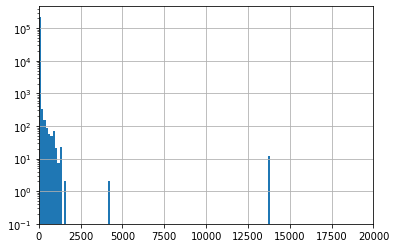

In [108]:
fig, ax = plt.subplots()
df.target.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
plt.xlim((0, 20000))

In [109]:
# Формирование train test valid данных

# df = pd.read_csv("../data/preprocessed_text_v1.csv", index_col=False)

df = df.drop(df[df['text'].map(str) == 'nan'].index)

train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
train.to_csv("../data/train_processed_data_regression.csv", index=False)
validate.to_csv("../data/validate_processed_data_regression.csv", index=False)
test.to_csv("../data/test_processed_data_regression.csv", index=False)

train.shape, validate.shape, test.shape

((136100, 13), (45367, 13), (45367, 13))

In [110]:
tokenize = lambda x: str(x).split()

TEXT = data.Field(sequential=True, tokenize=tokenize, batch_first=True)
# число всех сообщений пользователя в сети twitter;
TSTCOUNT = data.Field(sequential=False, use_vocab=False, dtype=torch.float)
# количество фоловеров пользователя (тех людей, которые читают пользователя);
TFOLL = data.Field(sequential=False, use_vocab=False, dtype=torch.float)
# количество друзей пользователя (те люди, которых читает пользователь);
TFRIEN = data.Field(sequential=False, use_vocab=False, dtype=torch.float)
# количество листов-подписок в которые добавлен твиттер-пользователь.
LISTCOUNT = data.Field(sequential=False, use_vocab=False, dtype=torch.float)
# число ретвитов
TARGET = data.Field(sequential=False, use_vocab=False, dtype=torch.float)

fields = [('text',TEXT), ('tstcount', TSTCOUNT), ('tfoll', TFOLL), ('tfrien', TFRIEN), ('listcount', LISTCOUNT), ('target', TARGET)]

In [111]:

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path="../data/",
                                        train="train_processed_data_regression.csv",
                                        validation="validate_processed_data_regression.csv",
                                        test="test_processed_data_regression.csv",
                                        format="csv",
                                        fields=fields,
                                        skip_header=True
)

In [112]:
print(vars(train_data[0]))

{'text': ['оставаться', 'самый', 'нужный', 'и', 'самый', 'близкие', ')', 'весь', 'остальной', 'уходить', ')', 'и', 'я', 'только', 'рада', ')', 'потому', 'что', 'я', 'никогда', 'сам', 'не', 'понять', 'нужный', 'я', 'человек', 'или', 'нет', ')'], 'tstcount': '0', 'tfoll': '0.03114683407120255', 'tfrien': '7.455109814399355e-05', 'listcount': '8.755868363244925e-05', 'target': '0.0001182382500738989'}


In [113]:
print(vars(valid_data[0]))

{'text': ['at_user', 'at_user', 'я', 'старушка', '(', '(', '('], 'tstcount': '1', 'tfoll': '0.00889131673866783', 'tfrien': '0.00037275549071996776', 'listcount': '0.0012927782112791034', 'target': '0.0003547147502216968'}


In [114]:
print(vars(test_data[0]))

{'text': ['at_user', 'привееть', ',', 'хелена', ':', ')', ')', ')', 'мимими', '.', '.', '.', 'пряник', ',', 'конфета', 'и', 'сирец'], 'tstcount': '0', 'tfoll': '0.004018833010286842', 'tfrien': '8.023719884989137e-05', 'listcount': '0.0003811377993412497', 'target': '0.00017735737511084836'}


In [115]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 136100
Number of validation examples: 45367
Number of testing examples: 45367


In [116]:
# TEXT.build_vocab(train_data, max_size=config.max_vocab_size)
TEXT.build_vocab(train_data, min_freq=2)
# TSTCOUNT.build_vocab(train_data)
# TFOLL.build_vocab(train_data)
# TFRIEN.build_vocab(train_data)
# LISTCOUNT.build_vocab(train_data)
# TARGET.build_vocab(train_data)

In [117]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
# print(f"Unique tokens in LABEL vocabulary: {len(TARGET.vocab)}")

Unique tokens in TEXT vocabulary: 33015


In [118]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: x.text,
    batch_size=config.batch_size,
    device=config.device)

In [119]:
# print('Train:')
# for batch in train_iterator:
#     print(batch)
    
# print('Valid:')
# for batch in valid_iterator:
#     print(batch)
    
# print('Test:')
# for batch in test_iterator:
#     print(batch)

In [120]:
print(TEXT.vocab.freqs.most_common(20))

[('(', 126857), (')', 116605), (',', 112838), ('.', 110646), ('at_user', 89459), (':', 64837), ('я', 64791), ('не', 44975), ('!', 39989), ('и', 36467), ('в', 35466), ('что', 23049), ('на', 22897), ('а', 21841), ('?', 21683), ('с', 20052), ('весь', 18848), ('ты', 18175), ('быть', 16970), ('это', 14896)]


In [121]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', '(', ')', ',', '.', 'at_user', ':', 'я', 'не']


In [122]:
import zipfile
import gensim
import wget

model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
# wget.download(model_url)
w2v_model = gensim.models.KeyedVectors.load('187/model.model')
numpy_embeddings = np.zeros(shape=[len(TEXT.vocab), config.embed_dim],dtype=np.float32)

for word in TEXT.vocab.itos:
    vector = w2v_model.get_vector(word)
    index  = TEXT.vocab.stoi[word]
    numpy_embeddings[index] = vector
    
pretrained_embeddings = torch.Tensor(numpy_embeddings).float()
pretrained_embeddings.shape

torch.Size([33015, 300])

In [123]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, hidden, output_dim, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc_text = nn.Linear(len(filter_sizes) * n_filters, hidden)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden + 4, output_dim)

    def forward(self, text, tstcount, tfoll, tfrien, listcount):
        
        tstcount, tfoll, tfrien, listcount = tstcount.unsqueeze(1), tfoll.unsqueeze(1), tfrien.unsqueeze(1), listcount.unsqueeze(1)
        
#         print(text)
#         print(tstcount)
#         print(tfoll)
#         print(tfrien)
#         print(listcount)
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)  
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
        
        text_features = self.fc_text(cat)
            
#         text_features = text_features.unsqueeze(1)
#         print(text_features.shape)
#         print(text_features)
#         print(tstcount.shape)
#         print(tstcount)
#         print(tfoll.shape)
#         print(tfoll)
#         print(tfrien.shape)
#         print(tfrien)
#         print(listcount.shape)
#         print(listcount)
        
#         tstcount = tstcount.permute(1, 0)
#         tfoll = tfoll.permute(1, 0)
#         tfrien = tfrien.permute(1, 0)
#         listcount = listcount.permute(1, 0)
        
        cat = torch.cat([text_features, tstcount, tfoll, tfrien, listcount], dim = 1)
        
#         print(cat.shape)
#         print(cat)
        
        result = self.fc(cat)
            
        return result

    
# INPUT_DIM = len(TEXT.vocab)
# EMBEDDING_DIM = config.embed_dim
# N_FILTERS = 128
# FILTER_SIZES = [2, 3]
# HIDDEN = 4
# OUTPUT_DIM = 1
# DROPOUT = 0.5
# PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# import torch.optim as optim

# criterion = nn.MSELoss()

# model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, HIDDEN, OUTPUT_DIM, DROPOUT, PAD_IDX)   
# model = model.to(config.device)
# optimizer = optim.Adam(model.parameters())
# criterion = criterion.to(config.device)




# for batch in train_iterator:
#     print(batch)
    
    
    
    
    
#     predictions = model(batch.text, batch.tstcount, batch.tfoll, batch.tfrien, batch.listcount).squeeze(1)
#     print(predictions.shape)
#     break

In [135]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = config.embed_dim
N_FILTERS = 128
FILTER_SIZES = [2, 3]
HIDDEN = 4
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, HIDDEN, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [136]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,097,793 trainable parameters


In [137]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 3.0550e-02, -3.5227e-01, -1.5996e-01,  ..., -6.7555e-01,
          1.6213e-01, -6.4838e-01],
        [ 5.5938e-01,  7.1610e-01, -5.2220e-02,  ..., -3.1100e-01,
          1.0994e+00, -7.4458e-01],
        [ 8.6657e-04,  2.8588e-03, -1.2546e-03,  ...,  2.7372e-03,
          3.3164e-03,  2.3352e-03],
        ...,
        [ 1.2707e-01, -2.0811e-02,  1.6323e-01,  ..., -1.2492e-03,
          2.0801e-01, -2.6840e-03],
        [-1.0621e+00,  2.0553e+00, -1.1423e+00,  ...,  3.4679e-01,
         -3.4598e-01, -1.1714e+00],
        [-2.3426e-02,  7.1213e-02, -9.7777e-02,  ...,  1.2438e-04,
         -1.1894e-03,  2.1802e-02]])

In [138]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [139]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.MSELoss()

model = model.to(config.device)
criterion = criterion.to(config.device)

In [140]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [141]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text, batch.tstcount, batch.tfoll, batch.tfrien, batch.listcount).squeeze(1)
        
        loss = criterion(predictions, batch.target)
        
#         acc = binary_accuracy(predictions, batch.target)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
#         epoch_acc += acc.item()
        
    return epoch_loss / len(iterator)

In [142]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text, batch.tstcount, batch.tfoll, batch.tfrien, batch.listcount).squeeze(1)
            
            loss = criterion(predictions, batch.target)
            
#             acc = binary_accuracy(predictions, batch.target)

            epoch_loss += loss.item()
#             epoch_acc += acc.item()
        
    return epoch_loss / len(iterator)

In [143]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [144]:
N_EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 216.562
	 Val. Loss: 32.595
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 18.176
	 Val. Loss: 1.141
Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 0.791
	 Val. Loss: 0.130
Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 0.134
	 Val. Loss: 0.124
Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 0.908
	 Val. Loss: 0.524
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.414
	 Val. Loss: 0.990
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.726
	 Val. Loss: 0.005
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.274
	 Val. Loss: 1.735
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.435
	 Val. Loss: 0.061
Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 0.727
	 Val. Loss: 0.005
Epoch: 11 | Epoch Time: 0m 21s
	Train Loss: 0.349
	 Val. Loss: 0.486
Epoch: 12 | Epoch Time: 0m 21s
	Train Loss: 0.572
	 Val. Loss: 0.051
Epoch: 13 | Epoch Time: 0m 22s
	Train Loss: 1.087
	 Val. Loss: 0.028
Epoch: 14 | Epoch Time: 0m 22s
	Train Loss: 0.624
	 Val. Loss: 0.193
Epoch: 15 | Epoch Time: 0m 22s

In [145]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f}')

Test Loss: 0.003
